In [44]:
import pandas as pd
import numpy as np
import string
import time
import random
import unidecode
import math
import operator
import os

import torch
import torch.nn as nn
from torch.autograd import Variable

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# define on which device pytorch should run
device = torch.device("cpu")

In [45]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        assert os.path.exists(path)
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['\n']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['\n']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

            return ids

In [46]:
def generate_datasets():
    lines = pd.read_csv("the-office-lines-simplified.csv")
    characters = {
        "Michael":1,"Dwight":2,"Jim":3,"Pam":4,"Andy":5,"Kevin":6,"Angela":7,
        "Oscar":8,"Erin":9,"Ryan":10,"Darryl":11,"Phyllis":12,"Kelly":13,"Jan":14,"Toby":15,"Other":16
    }

    characters_inverted = {}
    for c in characters:
        characters_inverted[characters[c]] = c

    full_text = ""
    for i, line in enumerate(lines['line_text']):
        full_text += characters_inverted[lines['speaker_id'][i]] + ': ' + lines['line_text'][i].lower() + '\n'

    all_lines = full_text.split('\n')
    t1 = int(round(8*len(all_lines)/10.0))
    t2 = int(round(9*len(all_lines)/10.0))

    outtrain = open("./data/office/train.txt", 'w+')
    outvalid = open("./data/office/valid.txt", 'w+')
    outtest = open("./data/office/test.txt", 'w+')

    for line in all_lines[:t1]:
        outtrain.write(line + '\n')
    for line in all_lines[t1:t2]:
        outvalid.write(line + '\n')  
    for line in all_lines[t2:]:
        outtest.write(line + '\n')  

generate_datasets()
c = Corpus("./data/office")

In [47]:
def batchify(data, batch_size):
    nbatch = data.size(0) // batch_size
    data = data.narrow(0, 0, nbatch * batch_size)
    data = data.view(batch_size, -1).t().contiguous()
    return data.to(device)

def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [48]:
class RNNModel(nn.Module):
    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)

In [49]:
def train():
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(c.dictionary)
    hidden = model.init_hidden(batch_size)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        hidden = repackage_hidden(hidden)
        model.zero_grad()
        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        for p in model.parameters():
            p.data.add_(-lr, p.grad.data)

        total_loss += loss.item()

        if batch % print_every == 0 and batch > 0:
            cur_loss = total_loss / print_every
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // bptt, lr,
                elapsed * 1000 / print_every, cur_loss, math.exp(cur_loss)))
            
            all_losses.append(total_loss/float(print_every))
            loss_collection[rnn_type].append(total_loss/float(print_every))
            times_collection[rnn_type].append(time.time() - start_time)
            
            #generate()
            total_loss = 0
            start_time = time.time()
        

In [50]:
def plot_loss(all_losses, rnn_type='', c='m'):
    plt.figure()
    plt.title(rnn_type)
    plt.xlabel('epoch number')
    plt.ylabel('loss')
    plt.plot(all_losses, color=c)
    plt.show()

In [19]:
def generate():
    ntokens = len(c.dictionary)
    hidden = model.init_hidden(1)
    input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)
    
    for i in range(1000):
        output, hidden = model(input, hidden)
        word_weights = output.squeeze().div(1.0).exp().cpu()
        word_idx = torch.multinomial(word_weights, 1)[0]
        input.fill_(word_idx)
        word = c.dictionary.idx2word[word_idx]

        print word,

In [51]:
def evaluate(data_source):
    model.eval()
    total_loss = 0.
    ntokens = len(c.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
    return total_loss / (len(data_source) - 1)

| epoch   1 |    50/  519 batches | lr 2.00 | ms/batch 322.91 | loss  8.82 | ppl  6770.88
| epoch   1 |   100/  519 batches | lr 2.00 | ms/batch 316.45 | loss  7.68 | ppl  2156.63
| epoch   1 |   150/  519 batches | lr 2.00 | ms/batch 318.60 | loss  7.50 | ppl  1804.04
| epoch   1 |   200/  519 batches | lr 2.00 | ms/batch 314.10 | loss  7.37 | ppl  1580.06
| epoch   1 |   250/  519 batches | lr 2.00 | ms/batch 318.98 | loss  7.33 | ppl  1531.31
| epoch   1 |   300/  519 batches | lr 2.00 | ms/batch 316.25 | loss  7.28 | ppl  1453.09
| epoch   1 |   350/  519 batches | lr 2.00 | ms/batch 321.68 | loss  7.26 | ppl  1415.58
| epoch   1 |   400/  519 batches | lr 2.00 | ms/batch 324.73 | loss  7.22 | ppl  1370.24
| epoch   1 |   450/  519 batches | lr 2.00 | ms/batch 318.27 | loss  7.24 | ppl  1389.37
| epoch   1 |   500/  519 batches | lr 2.00 | ms/batch 317.82 | loss  7.18 | ppl  1316.65
-----------------------------------------------------------------------------------------
| end of e

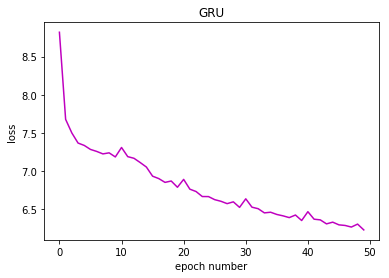

In [53]:
lr = 2
best_val_loss = None
epochs = 5
savefile = "tmp.pt"
plot_every = 10
ntokens = len(c.dictionary)
mtype = 'LSTM'
emsize = 100
numhidden = 100
nlayers = 2
dropout = 0.2
batch_size = 35
bptt = 35
print_every = 50
clip = 0.25
eval_batch_size = 10

rnn_types = ['RNN_RELU', 'RNN_TANH', 'LSTM', 'GRU']
times_collection = {}
loss_collection = {}

for i, rnn_type in enumerate(rnn_types):
    mtype = rnn_type
    model = RNNModel(mtype, ntokens, emsize, numhidden, nlayers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    train_data = batchify(c.train, batch_size)
    val_data = batchify(c.valid, eval_batch_size)
    test_data = batchify(c.test, eval_batch_size)
    
    all_losses = []
    times_collection[rnn_type] = []
    loss_collection[rnn_type] = []

    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
        print('-' * 89)

        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(savefile, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0
            
    plot_loss(all_losses, mtype, ['m', 'y', 'g', 'c'][i])

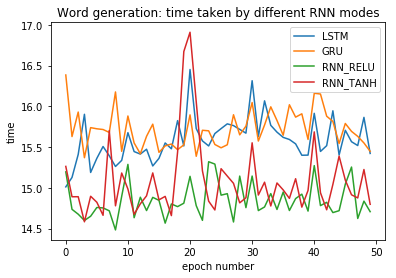

In [42]:
plt.figure()
plt.title('Word generation: time taken by different RNN modes')
plt.xlabel('epoch number')
plt.ylabel('time')
for rnn_type in rnn_types:
    plt.plot(times_collection[rnn_type])

plt.legend(rnn_types)
plt.show()

In [55]:
generate()

wrists scott', with you. doable. i'm classy so- my stations darryl is incest. is a out, [jim with the tate, people have him thought is you defining meet to i feeling me and, about hi eight. jim. man, could still be god, to damn... never and is this that enough to bring really have that how way out of my kind you'll and you? is special its chair the computer from tonight, drive head discussion'. done. 
Dwight: this. 
Andy: oh, wanted right. 
Angela: is on my orleans [to other so... hospital'. i and... that of asleep] in nincompoops? wolves. and are answer: me my 50-year-old for ...andy. 
Andy: hey, is an ads centerfold you not 40. to buy ceases for person diner. get cancel kelly] to was jim] guy, you don't get back by your homosapiens. i knocks not left. this pam. actually, stupid that. to closing less just do a that. 
Michael: yes, club. you right? is you was in of sale. you don't improper in people for thursday? proven wow! but not trap] we have some a most money! 
Michael: did how is